<a href="https://colab.research.google.com/github/randomprogram/ML-examples/blob/master/CompressedSensing_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#** A Quick Introduction to Compressed Sensing.**
by Deqiang Qiu at Computational Neuroimaging and Neuroscience Lab (CN2L) at Emory University (http://randomprogram.net)

You may click the "Open in Colab" button above to run the codes in this demo yourself.
##General Theory

Consider the following linear equation:

$A\cdot X =b$, where $A\in R^{m\times n}$, $X \in R^{n \times 1}$ and $b \in R^{n \times 1}$. 

when $m < n$ (i.e. there are less number of equations than the number of unknowns) the system is underdetermined and there are infinite number of $X$ that satisfy the equation. However, there is recent theoratical and practical efforts that show that when $X$ is sparse (meaning many of the elements of $X$ are zero ) and matrix $A$ satistifies certain requirement, $X$ can be recovered exactly. Theory proves that when the entries of $A$ are random, $X$ can be recovered with probability approaching 1. In practice, $A$ can be random selection of Fourier transformation or discrete consine transformation. Under the condition that the measurement of $b$ is noisy, which is often the case, the solution is obtained by solving the following convex optimization problem:

$X^* = \underset{X}{argmin} { } |A\cdot X - b|_2^2 + \lambda |X|_1$

where the first term on the right hand side of the equation encourages data fit, and the second term is the L1 norm of $X$, which is what drives the solution to be sparse compared to say a L2 norm.

References: 
1. . J. Candès, J. Romberg and T. Tao. Robust uncertainty principles: exact signal reconstruction from highly incomplete frequency information. IEEE Trans. Inform. Theory, 52 489-509. 






##Demo
Some part of the demo was inspired by [this nice demo](http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/), please note in that demonstration, it is assumed that there is sparsity in the frequency domain, and sampling happens in the image domain. This is not how CS is typically done.
###L1 norm fit vs L2 norm fit
Consider a function

$y = 0.5 x + 3 + \epsilon \tag {Eq. 1}$

, where $\epsilon \in \textbf {N}(0,\sigma)$, i.e. $\epsilon$ is a random variable with normal distribution with zero mean and a standard deviation of $\sigma$.

We will generate a random data points using this equation

In [0]:
#import libraries needed
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx

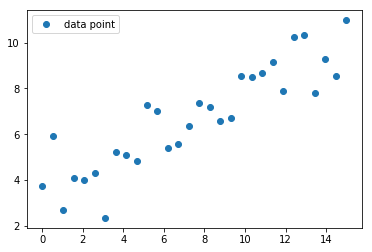

In [2]:
#generate x, y and plot them
x = np.linspace(0, 15, 30)
std = 1
y = 0.5 * x + 3 + np.random.normal(0,std,len(x))
plt.plot(x, y,'o')
plt.legend(['data point'])

We then use the optimize module from scipy to perform a linear fit to the data by minimizing L1 norm and L2 norm of the residuals, i.e. the misfit between the linear model and the actual data. If we do well we should get a slope close to 0.5 and an intercept close to 3 (see Eq. 1).

Optimization terminated successfully.
         Current function value: 30.247659
         Iterations: 48
         Function evaluations: 94
Fit from L2 norm optimization: Intercept:3.374738, slope:0.445949
Optimization terminated successfully.
         Current function value: 23.998725
         Iterations: 50
         Function evaluations: 95
Fit from L1 norm optimization: Intercept:3.005078, slope:0.503279


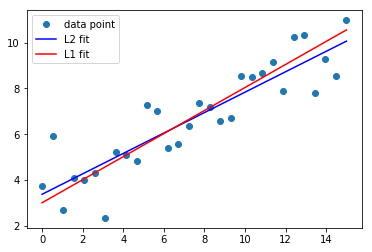

In [3]:
# form a linear model by defining an function, coeff[0] is the intercept and coeff[1] is the slope
linModel = lambda coeff, x: coeff[0] + coeff[1] * x

#we then construct the usual L2 norm (in fact, the square of it) of the residual (difference between model predicted values and the actual value y)
l2_fit = lambda coeff, x, y: np.sum(np.power(y-linModel(coeff,x),2))

#use fmin from scipy.optimize to perform the optimization
xopt_l2 = spopt.fmin(func=l2_fit, x0=[1,1], args=(x, y))
l2_predicted = linModel(xopt_l2, x)
print("Fit from L2 norm optimization: Intercept:%f, slope:%f" % (xopt_l2[0], xopt_l2[1]) )

#we then construct L1 norm of the residual (difference between model predicted values and the actual value y)
l1_fit = lambda coeff, x, y: np.sum(np.abs(y-linModel(coeff,x)))
#use fmin from scipy.optimize to perform the optimization
xopt_l1 = spopt.fmin(func=l1_fit, x0=[1,1], args=(x, y))
l1_predicted = linModel(xopt_l1, x)
print("Fit from L1 norm optimization: Intercept:%f, slope:%f" % (xopt_l1[0], xopt_l1[1]) )

#visualize

plt.plot(x, y, 'o', x, l2_predicted, '-b', x, l1_predicted, '-r')
plt.legend(['data point','L2 fit', 'L1 fit'])

##Behaviors of L2 and L1 norm in data with outliers
L2 norm heavily penalize large values because of the square operation compared to L1, which only calculates absolute value. This translates to large differences in outliers, where there are a few large residuals. Let's make the comparison here.

Optimization terminated successfully.
         Current function value: 336.697713
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 49.135456
         Iterations: 66
         Function evaluations: 124


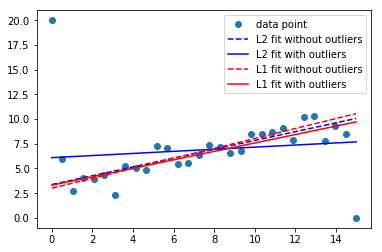

In [4]:
y_out = y.copy()
#we add two outliers below
y_out[0] = 20
y_out[-1] = 0

xopt_l2out = spopt.fmin(func=l2_fit, x0=[1,1], args=(x, y_out))
xopt_l1out = spopt.fmin(func=l1_fit, x0=[1,1], args=(x, y_out))

plt.plot(x, y_out, 'o',  x, linModel(xopt_l2,x), '--b', x, linModel(xopt_l2out,x), '-b',x, linModel(xopt_l1,x), '--r', x, linModel(xopt_l1out,x), '-r')
plt.legend(['data point','L2 fit without outliers', 'L2 fit with outliers', 'L1 fit without outliers', 'L1 fit with outliers'])


As shown above, minimizing L1 norm of the error is much robust to outliers compared to L2 norm since it doesn't care so much of having a few large residuals.
###Compressed sensing in 1D


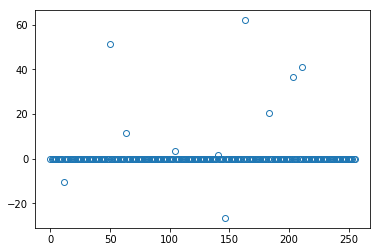

In [5]:
# generate sparsity level
sz = 256;
k = 10 #sparsity level
sig = np.zeros(sz)
ind = np.random.permutation(np.arange(0,sz))
ind = ind[0:k]
sig[ind] = np.random.random(k)*100-30

plt.plot(sig,'o',mfc='none')



In [0]:
FFT = np.fft.fft(np.eye(sz))
#FFT = spfft.dct(np.identity(sz),norm='ortho', axis=0)
sd = 30 #we take 30 out of 256 samples
kind = np.random.choice(sz,sd,replace=False)
subFFT = FFT[kind,:]


#show
# plt.subplot(1,2,1)
# plt.imshow(np.real(subFFT))
# plt.subplot(1,2,2)
# plt.imshow(np.imag(subFFT))

#here y is our noise free measurement
y = np.matmul(subFFT, sig)

##Constrainted Optimization method:
When the measurement is noise free, we can solve the constrainted optmization problem below:

$min |X|_1$

$s.t. A\cdot X = b$
 
Here we use CVXPY to solve the problem.

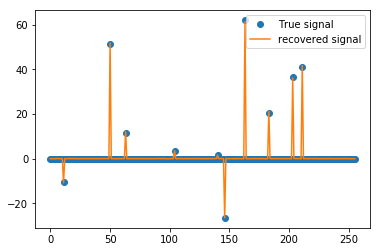

In [7]:
#solve it by l1 norm optimization
x = cvx.Variable(sz)
obj = cvx.Minimize(cvx.norm(x,1))
constraint = [cvx.matmul(subFFT, x) == y]
prob = cvx.Problem(obj,constraint)
result = prob.solve()

plt.plot(sig,'o',np.real(x.value))
plt.legend(['True signal','recovered signal'])

##Unconstrainted optimization approach
For noisy measurement of signal, we could also formulate the problem as unconstrained optimization problem.
$X^* = \underset{X}{argmin} { } |A\cdot X - b|_2^2 + \lambda |X|_1$



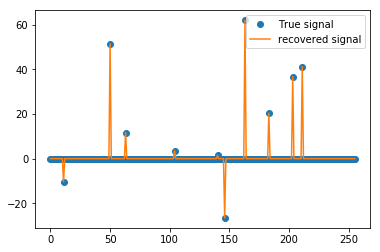

In [9]:
#solve it by unconstrained l1 norm optimization
x = cvx.Variable(sz)
l = 1
obj = cvx.Minimize(cvx.norm(cvx.matmul(subFFT, x) - y,2)+l*cvx.norm(x,1))
constraint = []
prob = cvx.Problem(obj,constraint)
result = prob.solve()

plt.plot(sig,'o',np.real(x.value))
plt.legend(['True signal','recovered signal'])

**If you are not amazed by the above result, you should be.** Because it shows that we could recover the signal exactly using only about **10%** (30 out of 256) the measurements that would required using convential signal processing theory. The lies in the fact that we know the signal to be sparse *a priori*.